# Homework 4

### Sofía Gerard &  Román Vélez

march 4, 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from tqdm import tqdm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


---
# Problem 1: Spiegelhalter's mortality data


## S1: Load data

In [2]:
# spiegelhalter data
df_spiegelhalter = pd.DataFrame({
    'dose': [1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.8610, 1.8839],
    'deads': [6, 13, 18, 28, 52, 53, 61, 60],
    'exposed': [59, 60, 62, 56, 63, 59, 62, 60]
})
df_spiegelhalter


,dose,deads,exposed
0,1.6907,6,59
1,1.7242,13,60
2,1.7552,18,62
3,1.7842,28,56
4,1.8113,52,63
5,1.8369,53,59
6,1.8610,61,62
7,1.8839,60,60


In [3]:
# part 1: centralize dose
df_spiegelhalter['dose_c'] = df_spiegelhalter['dose'] - df_spiegelhalter['dose'].mean()
df_spiegelhalter

,dose,deads,exposed,dose_c
0,1.6907,6,59,-0.102725
1,1.7242,13,60,-0.069225
2,1.7552,18,62,-0.038225
3,1.7842,28,56,-0.009225
4,1.8113,52,63,0.017875
5,1.8369,53,59,0.043475
6,1.8610,61,62,0.067575
7,1.8839,60,60,0.090475


## S2: Init model

In [4]:
# part 2: fit a logit model using pymc
with pm.Model() as model_logit:
    # priors
    alpha = pm.Normal('alpha', mu=0, tau=1e-3)
    beta = pm.Normal('beta', mu=0, tau=1e-3)

    # expected value (use logit link)
    p = pm.math.invlogit(alpha + beta * df_spiegelhalter['dose_c'])  # not determinstic to avoid trace

    # deaths
    deaths = pm.Binomial('deaths', n=df_spiegelhalter['exposed'], p=p, observed=df_spiegelhalter['deads'])
    # (wip)

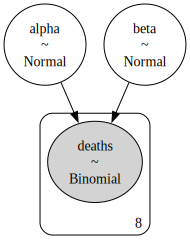

In [5]:
# part 2.1: look graph of the model
pm.model_to_graphviz(model_logit)


## S3: Prior predictive checks

Sampling: [alpha, beta, deaths]


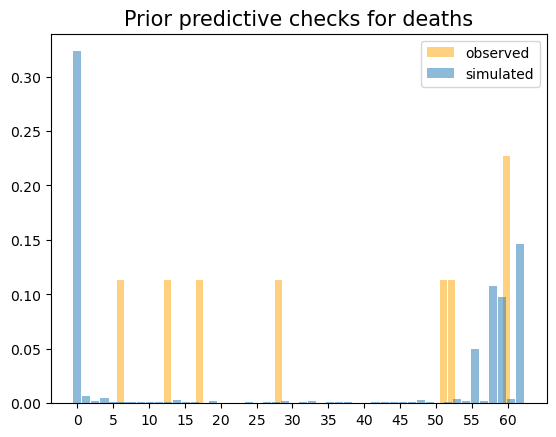

In [6]:
# part 3: prior predictive checks
with model_logit:
    prior_checks = pm.sample_prior_predictive(samples=1000)

# 3.1: plot observed data
az.plot_dist(
    df_spiegelhalter['deads'],
    kind='hist',
    hist_kwargs={'bins': 50, 'alpha': 0.5},
    label='observed',
    color='orange'
)

# 3.2: plot prior predictive checks
az.plot_dist(
    prior_checks.prior_predictive['deaths'],
    kind='hist',
    hist_kwargs={'bins': 50, 'alpha': 0.5},
    label='simulated'
)

# show plot
plt.legend()
# xticks each 10 values
plt.xticks(np.arange(0, df_spiegelhalter['deads'].max() + 1, 5))
# add title
plt.title('Prior predictive checks for deaths', fontsize=15)
plt.show()

Maybe the model is misspecified, because the prior predictive checks are not similar, at least in the left tail.

## Step 4: fit the model

In [7]:
# part 4: fit model
with model_logit:
    trace_logit = pm.sample(
        1000, tune=1000, random_seed=42, chains=4,
        progressbar=True, cores=4
        )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


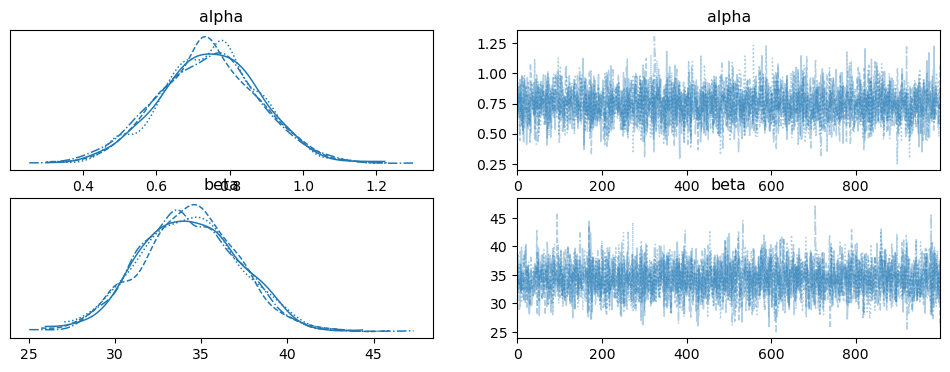

In [8]:
# part 4.1: plot trace
az.plot_trace(trace_logit)
plt.show()

In [9]:
# part 4.2: get summart of the trace
az.summary(trace_logit, round_to=2, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.74,0.14,0.52,0.97,0.00,0.00,3570.70,2796.23,1.0
beta,34.30,2.89,29.90,39.30,0.05,0.03,3439.76,2825.02,1.0


array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

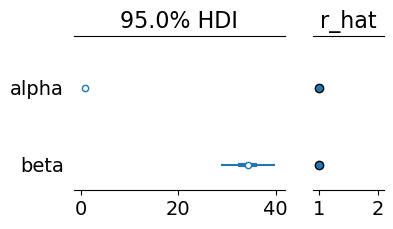

In [10]:
# part 4.3: plot forest plot
az.plot_forest(
    trace_logit,
    combined=True,
    hdi_prob=0.95,
    r_hat=True,
    var_names=['alpha', 'beta'],
    figsize=(4, 2)
    )

## S5: Posterior predictive checks

In [11]:
# part 5: posterior predictive checks
with model_logit:
    post_checks = pm.sample_posterior_predictive(
        trace_logit, random_seed=42
    )

Sampling: [deaths]


In [12]:
post_checks

Inference data with groups:
	> posterior_predictive
	> observed_data

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='deaths'>

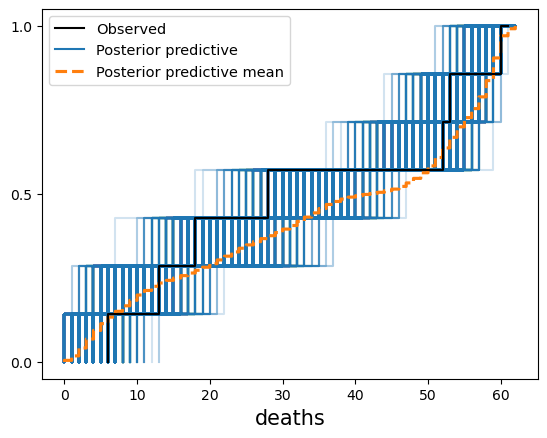

In [13]:
# part 5: plot ppc (doubt!!!, not knowing how and what to plot)
az.plot_ppc(post_checks, data_pairs={'deaths': 'deaths'}, kind='cumulative')

---
# Problem 2: conditional distributions

## S1: Marginal distribution

Suppose 
$f(x|y) \propto y e^{-yx}$
$f(y|x) \propto y e^{-xy}$

for $0 < x < B < \infty$ and $0 < y < B < \infty$ 

Get marginal for $X$ when $B=10$ using Gibbs sampling.

In [34]:
# fix seed
RNG = np.random.default_rng(seed=42)

In [35]:
# gibbs sampling 
def rvs_trunc_exponential(lambd, B=10):
    # sampling
    z = RNG.exponential(scale=1/lambd, size=1)
    #  obsrevations beyond B
    z = z.clip(max=B)
    return z[0]  # get value

# sample gibbs
def gibbs_sampling_trunc_exp(n=100, B=10, init_value=1/10):
    # generate n samples
    x = np.empty(shape=n)
    y = np.empty(shape=n)

    # init value
    x[0] = init_value
    y[0] = rvs_trunc_exponential(lambd=x[0], B=B)
    for i in tqdm(range(1, n)):
        x[i] = rvs_trunc_exponential(lambd=x[i-1], B=B)
        y[i] = rvs_trunc_exponential(lambd=x[i-1], B=B)

    return np.array([x, y]).T


doubt: is this what we want??

In [42]:
# sample when B = 10
xy_gibbs_sampling = gibbs_sampling_trunc_exp(n=1000, B=10)
xy_gibbs_sampling

array([[1.00000000e-01, 1.00000000e+01],
       [8.37043219e+00, 1.00000000e+01],
       [7.62568588e-02, 5.38730016e-03],
       ...,
       [5.68858895e-01, 3.72417553e-01],
       [8.78546615e-01, 3.41188854e-01],
       [5.83591097e-01, 1.51650574e+00]])

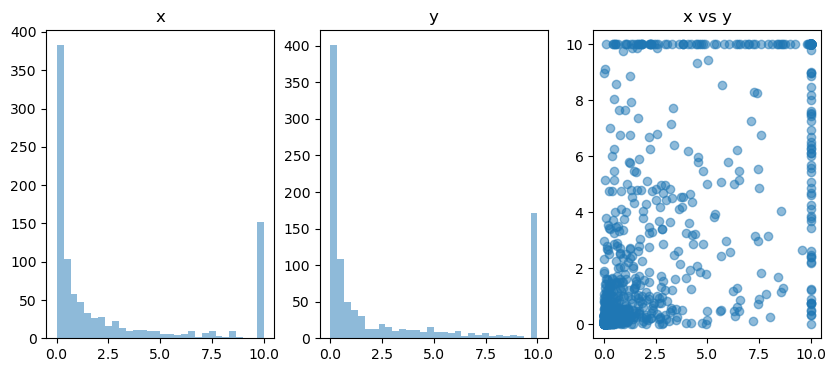

In [43]:
# plot histogram of x and y
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
# x histogram
ax[0].hist(xy_gibbs_sampling[:, 0], bins=30, alpha=0.5)
ax[0].set_title('x')
# y histogram
ax[1].hist(xy_gibbs_sampling[:, 1], bins=30, alpha=0.5)
ax[1].set_title('y')
# scatter plot x vs y
ax[2].scatter(xy_gibbs_sampling[:, 0], xy_gibbs_sampling[:, 1], alpha=0.5)
ax[2].set_title('x vs y')
# show plot
plt.show()

## S2: Suppose $B = \infty$

In [44]:
# sample when B = 10
xy_gibbs_sampling = gibbs_sampling_trunc_exp(n=1000, B=np.inf)
xy_gibbs_sampling

array([[1.00000000e-01, 4.68619680e+00],
       [4.08483094e+00, 7.45207564e+00],
       [4.07588952e-02, 2.03959729e-02],
       ...,
       [6.52927864e+18, 1.41926511e+21],
       [5.21799863e-20, 1.34821018e-19],
       [6.25414204e+18, 2.86699011e+19]])

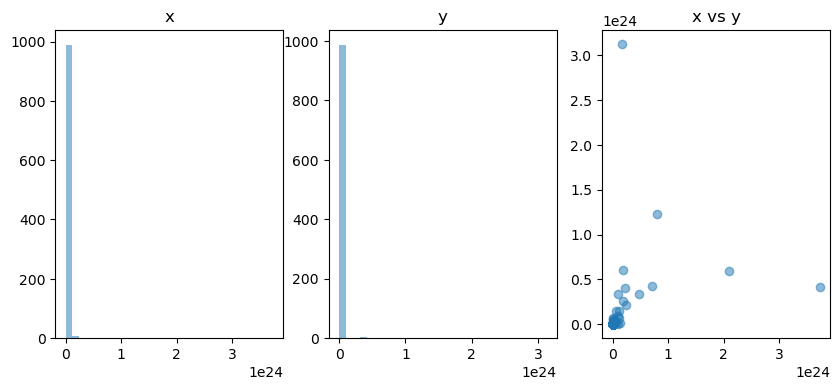

In [45]:
# plot histogram of x and y
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
# x histogram
ax[0].hist(xy_gibbs_sampling[:, 0], bins=30, alpha=0.5)
ax[0].set_title('x')
# y histogram
ax[1].hist(xy_gibbs_sampling[:, 1], bins=30, alpha=0.5)
ax[1].set_title('y')
# scatter plot x vs y
ax[2].scatter(xy_gibbs_sampling[:, 0], xy_gibbs_sampling[:, 1], alpha=0.5)
ax[2].set_title('x vs y')
# show plot
plt.show()

---
# Pregunta 3: Densidad Poli-Cauchy

In [8]:
from scipy.stats import norm

## S1: Poli Cauchy Density

In [27]:
# params
a_vector = np.array([1, 2, 2, 6, 7, 8])

# poli-cauchy distribution
def dpoli_cauchy(x, a=a_vector, log=False):
    # kernel
    kernel = 1 + (x - a)**2

    # get distribution
    if log:
        return - np.sum(np.log(kernel)) - len(a) * np.log(np.pi)
    else:
        return np.prod(1 / (np.pi * kernel))

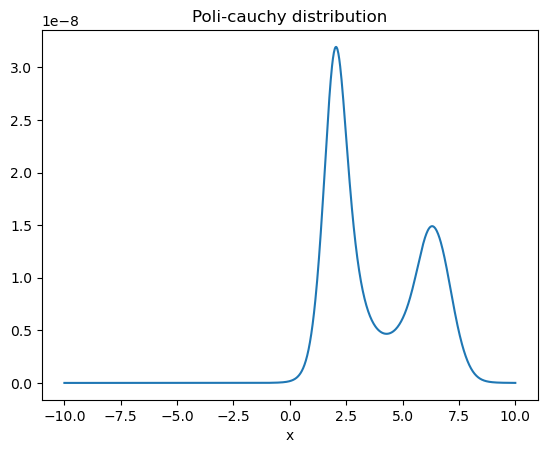

In [34]:
# plot poli-cauchy
x = np.linspace(-10, 10, 1000)
y = [dpoli_cauchy(x_i) for x_i in x]
plt.plot(x, y)
plt.title('Poli-cauchy distribution')
# x axis
plt.xlabel('x')
plt.show()


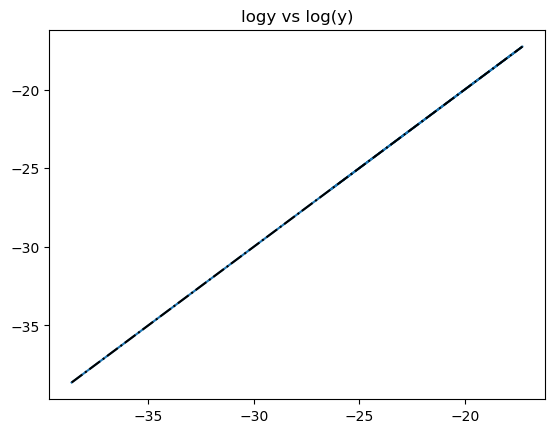

In [35]:
# look if log is working
logy = [dpoli_cauchy(x_i, log=True) for x_i in x]

# look logy vs log(y)
plt.plot(logy, np.log(y))
plt.title('logy vs log(y)')
# add abline at 45 degree
plt.plot([np.min(logy), np.max(logy)], [np.min(logy), np.max(logy)], 'k-.')
plt.show()

## S2: Metropolis-Hastings algorithm for poli-cauchy with normal proposal

In [81]:
# metropolis hastings
RNG = np.random.default_rng(seed=42)
def mh_random_walk(f, x0=0, sigma=1, n=1e+4, burn_in=1e+3):
    # metropolis-hastings ratio
    def mh_ratio(x, y):
        # f & sigma are global
        r = (
            (f(y) * norm.pdf(x, loc=y, scale=sigma)) /
            (f(x) * norm.pdf(y, loc=x, scale=sigma))
            )
        return np.where(r < 1, r, 1)  # min between ratio and 1

    # number of total samples after burn-in
    n = int(n)
    burn_in = int(burn_in)
    n_samples = int(n + burn_in)

    # mh algorithm with random walk #
    # step 1: init value
    z = np.empty(shape=n_samples)  # init num of random samples
    acceptance = np.empty(shape=n_samples-1)
    z[0] = x0

    # step 2: markov chain
    for i in tqdm(range(1, n_samples)):
        # sample new state from random walk
        y = RNG.normal(loc=z[i-1], scale=sigma, size=1)[0]  # get element
        # get acceptance probabiliy
        alpha = mh_ratio(z[i-1], y)
        # acceptance - rejection
        u = RNG.uniform(size=1)[0]
        acceptance[i-1] = np.sign(alpha - u)
        # update
        z[i] = y if acceptance[i-1] >= 0 else z[i-1]

    # step 3: burn-in
    z = z[burn_in:]
    acceptance = acceptance[burn_in:]

    return {
        'sample': z,
        'rejection': np.mean(acceptance < 0)
    }

def plot_sample(dict_mh, f):
    # plot chain and histogram in same figure
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # plot chain
    ax[0].plot(dict_mh['sample'], alpha=0.5, linewidth=0.5)
    ax[0].set_title('Chain')
    # add rejection rate
    ax[0].text(
        0, 0,
        f'Rejection: {dict_mh["rejection"]:.2%}',
        transform=ax[0].transAxes
        )
    # xtitle
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('x')
    # plot histogram normalized
    ax[1].hist(dict_mh['sample'], bins=30, alpha=0.5, density=True)
    ax[1].set_title('MH Sampling')
    ax[1].set_xlabel('x')

    # show plot
    plt.show()

100%|██████████| 10999/10999 [00:01<00:00, 6550.83it/s]


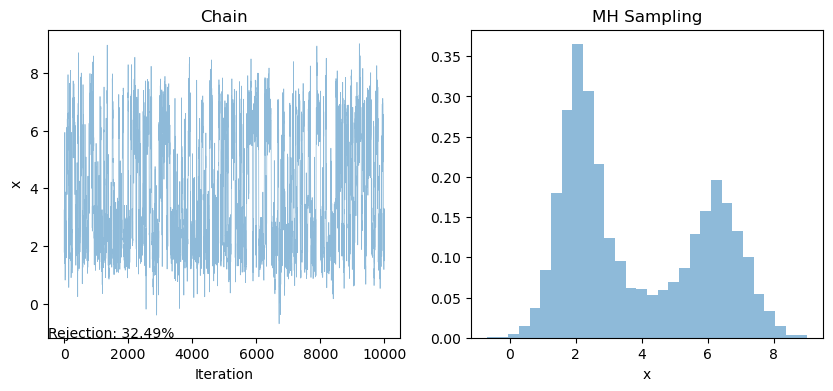

In [82]:
# sample for C = 1
x_policauchy = mh_random_walk(
    f=dpoli_cauchy,
    x0=0,
    sigma=1,
)
plot_sample(x_policauchy, dpoli_cauchy)

100%|██████████| 10999/10999 [00:01<00:00, 6649.49it/s]


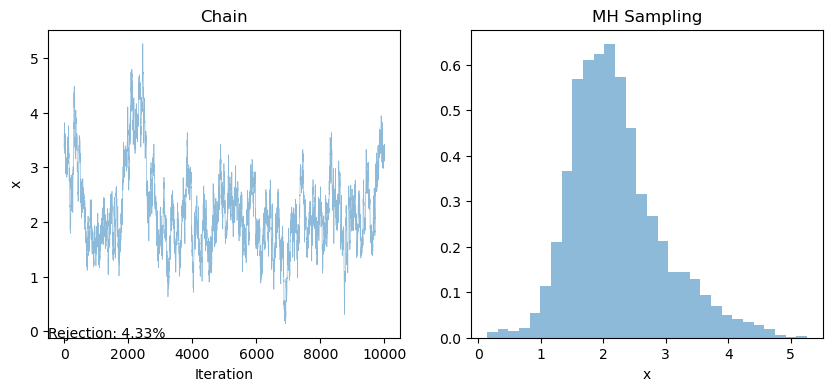

In [87]:
# sample for C = 0.1
x_policauchy = mh_random_walk(
    f=dpoli_cauchy,
    x0=0,
    sigma=0.1
)
plot_sample(x_policauchy, dpoli_cauchy)

  0%|          | 0/10999 [00:00<?, ?it/s]

100%|██████████| 10999/10999 [00:01<00:00, 6668.66it/s]


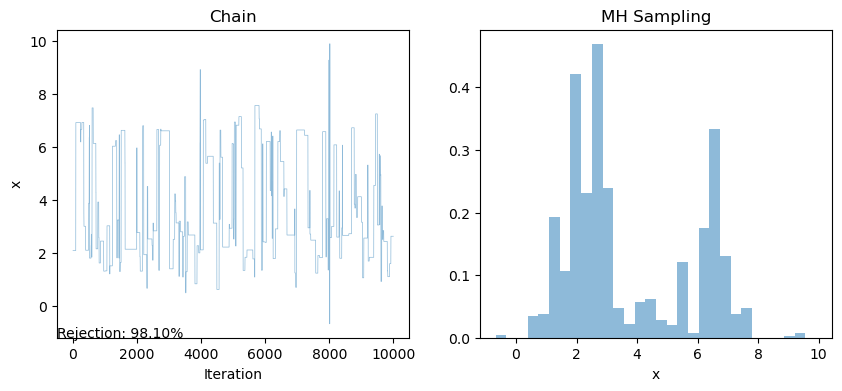

In [85]:
# sample for C = 100
x_policauchy = mh_random_walk(
    f=dpoli_cauchy,
    x0=0,
    sigma=100
)
plot_sample(x_policauchy, dpoli_cauchy)

## S3: Estimate $\mathbb{P}[6 < Y <8]$

100%|██████████| 10999/10999 [00:01<00:00, 6115.35it/s]


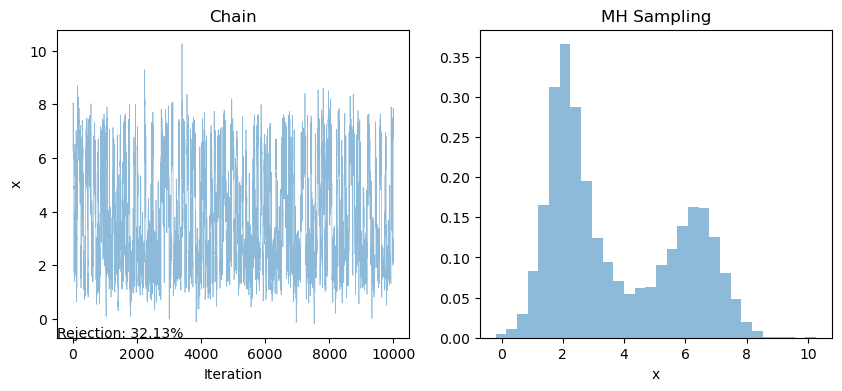

In [88]:
# sample for C = 1
x_policauchy = mh_random_walk(
    f=dpoli_cauchy,
    x0=0,
    sigma=1,
    n=1e+4,
    burn_in=1e+3
)
plot_sample(x_policauchy, dpoli_cauchy)


In [92]:
# get proba
proba_6and8 = np.mean((x_policauchy['sample'] > 6) & (x_policauchy['sample'] < 8))
print(f'P[6 < Y < 8] = {proba_6and8:.2%}')

P[6 < Y < 8] = 21.81%


---
# Problem 4: Gamma-Poisson Distribution

We know that
$$
f(x, y) = \frac{x^{a + y - 1} e^{-(1 + b)x}b^{a}}{\Gamma(a) y!}
$$

Then
$$
X|Y \sim \text{Gamma}(a + y, 1 + b),
$$
and
$$
Y|X \sim \text{Poisson}(x).
$$

In [8]:
# fix seed
RNG = np.random.default_rng(seed=42)

In [18]:
# sample gibbs for gamma-poisson
def gibbs_sampling_gammapoisson(
    n=100, init_value=[1, 1], a=1, b=1
    ):
    # generate n samples
    n = int(n)
    x = np.empty(shape=n)
    y = np.empty(shape=n)

    # init value
    x[0] = init_value[0]
    y[0] = init_value[1]
    for i in tqdm(range(n)):
        x[i] = RNG.gamma(
            shape=a+y[i-1], scale=1/(1 + b), size=1
            )[0]
        y[i] = RNG.poisson(lam=x[i])
    
    return np.array([x, y]).T


In [31]:
# sample when a = 1 and b = 1
xy_gibbs_sampling = gibbs_sampling_gammapoisson(
    n=1000, init_value=[1, 1], a=1, b=1
)

100%|██████████| 1000/1000 [00:00<00:00, 120146.20it/s]


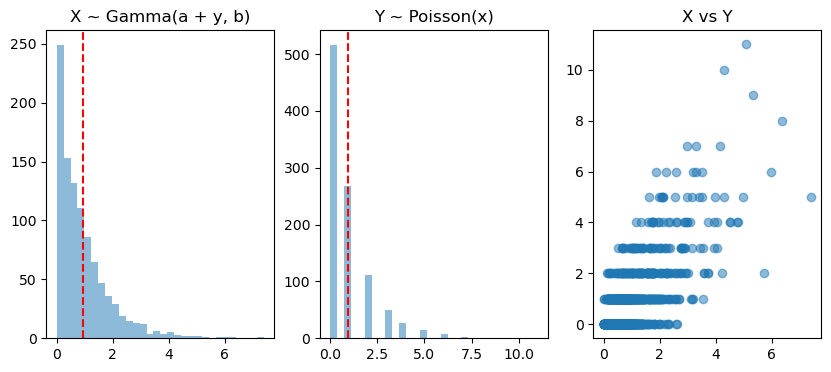

Mean of X: 0.95
Mean of Y: 0.92


In [32]:
# plot histogram of x and y
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
# x histogram
ax[0].hist(xy_gibbs_sampling[:, 0], bins=30, alpha=0.5)
# add mean
ax[0].axvline(np.mean(xy_gibbs_sampling[:, 0]), color='red', linestyle='--')
ax[0].set_title('X ~ Gamma(a + y, b)')
# y histogram
ax[1].hist(xy_gibbs_sampling[:, 1], bins=30, alpha=0.5)
# add mean
ax[1].axvline(np.mean(xy_gibbs_sampling[:, 1]), color='red', linestyle='--')
ax[1].set_title('Y ~ Poisson(x)')
# scatter plot x vs y
ax[2].scatter(xy_gibbs_sampling[:, 0], xy_gibbs_sampling[:, 1], alpha=0.5)
ax[2].set_title('X vs Y')
# show plot
plt.show()

print(f"Mean of X: {np.mean(xy_gibbs_sampling[:, 0]):.2f}")
print(f"Mean of Y: {np.mean(xy_gibbs_sampling[:, 1]):.2f}")

# Problem 5: Adyacent Bernoulli Matrix

## Build $N(X)$ & $D(X)$ & $\pi(X)$

In [2]:
# get computational wrappers
def total_successes(X: np.ndarray) -> int:
    # sum of all elements
    return np.sum(X)


def number_different_neighbours(X: np.ndarray) -> int:
    # unpack shape
    n = X.shape[0]

    # matrix of horizontal different neighbours
    M = np.zeros(shape=(n * n, n * n))
    np.fill_diagonal(M, 1)  # 1's diagonal 
    np.fill_diagonal(M[:, 1:], -1)  # -1's upper diagonal
    M[(n-1)::n, :] = 0  # fill each n row with 0's (no end of row neighbor)
    
    # get horizontal and vertical differences
    d_horizontal = np.abs(M @ X.flatten())
    d_vertical = np.abs(M @ X.T.flatten().reshape(-1, 1))

    return d_horizontal.sum() + d_vertical.sum()



In [172]:
# ex: look for number of different neighbours
X = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 0]
    ])

# success & different neighbours
N_x = total_successes(X)
D_x = number_different_neighbours(X)
print(f"Total successes: {N_x}")
print(f"Number of different neighbours: {D_x}")

Total successes: 3
Number of different neighbours: 10.0


## S2: Metropolis-Hastings algorithm

In [3]:
# fix seed
RNG = np.random.default_rng(seed=42)

In [151]:
# matrix density
def dmatrix(X: np.ndarray, p: int, lam: int) -> int:
    """
    X: matrix of 0's and 1's
    p: probability of success
    lam: lambda value
    """
    # shape of x
    n = X.shape[0]
    # get total successes
    n_x = total_successes(X)
    # get number of different neighbours
    d_x = number_different_neighbours(X)
    # distribution value
    return p**n_x * (1 - p)**(n**2 - n_x) * np.exp(-lam * d_x)


# matrix kernels
def sample_q1(X: np.ndarray, n: int, p: float):
    # sample matrix
    return RNG.binomial(n=1, p=p, size=(n, n))


def sample_q2(X: np.ndarray, n: int, p: float):
    # sample i,j from X with even probability
    i, j = RNG.integers(0, n, size=2)
    # sample blli
    X[i, j] = RNG.binomial(n=1, p=0.5, size=1)[0]
    return X


# metroplis-hastings
def mh_blli_matrix(
    f, qkernel, n_matrix=4, p=0.5, lam=0, n=1e+4, burn_in=1e+3
    ):
    # metroplis hastings ratio
    def mh_ratio(X, Y):
        fy = f(Y, p, lam)
        fx = f(X, p, lam)
        return np.minimum(fy / fx, 1)

    # number of total samples after burn-in
    n = int(n)
    burn_in = int(burn_in)
    n_samples = int(n + burn_in)

    # step 1: init value
    Z = np.empty(shape=(n_samples, n_matrix, n_matrix), dtype=int)  # init num of random samples
    acceptance = np.empty(shape=n_samples-1)
    Z[0] = np.eye(n_matrix)

    # step 2: markov chain
    for i in tqdm(range(1, n_samples)):
        # sample new state
        Y = qkernel(Z[i-1].copy(), n_matrix, p)
        # get acceptance probabiliy
        alpha = mh_ratio(Z[i-1], Y)
        # acceptance - rejection
        u = RNG.uniform(size=1)[0]
        acceptance[i-1] = np.sign(alpha - u)
        # update
        Z[i] = Y if acceptance[i-1] >= 0 else Z[i-1]
    
    # step 3: burn-in
    Z = Z[burn_in:]
    acceptance = acceptance[burn_in:]

    return {
        'sample': Z,
        'rejection': np.mean(acceptance < 0)
    }


# graph X's chain as flatten matrix
def plot_X_heatmap(dict_mh):
    # plot chain and histogram in same figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    n_sim = dict_mh['sample'].shape[0]
    # reshape matrix
    Z = dict_mh['sample'].reshape(n_sim, -1).T
    # plot chain as black and white
    sns.heatmap(Z, cmap='binary', ax=ax)
    # add xaxis
    ax.set_xlabel('Iteration')
    # xticks each 500 values
    ax.set_xticks(np.arange(0, n_sim, 500))
    ax.set_ylabel('Matrix')
    # add title
    ax.set_title('Matrix Chain')
    # add vline each y value 
    for i in range(1, Z.shape[0]):
        ax.axhline(i, color='gray', linestyle='-', linewidth=0.5)
    # add hline each x value
    for i in range(1, n_sim):
        ax.axvline(i, color='gray', linestyle='-', linewidth=0.5)
    # show plot
    plt.show()
    

# estimate proba of all diagonal being 1s
def proba_all_diagonal_ones(dict_mh):
    # get samples
    Z = dict_mh['sample']
    # get number of samples
    n_size = Z.shape[1]
    # get proba of matrix which trace is equal to n
    return np.mean(np.trace(Z, axis1=1, axis2=2) == n_size)

### Ex: sample for $p = 0.5$ and $\lambda = 0$

In [152]:
# sample for p = 0.5 and lam = 0 for kernel_q2
X_q2 = mh_blli_matrix(
    f=dmatrix,
    qkernel=sample_q2,
    n_matrix=3,
    p=0.5,
    lam=0,
    n=1e+2,
    burn_in=1e+1
)

100%|██████████| 109/109 [00:00<00:00, 4542.40it/s]


In [153]:
# look sample
X_q2['sample']

array([[[1, 1, 0],
        [1, 1, 1],
        [0, 0, 0]],

       [[1, 1, 0],
        [1, 1, 1],
        [0, 0, 0]],

       [[1, 1, 0],
        [1, 1, 1],
        [1, 0, 0]],

       [[1, 1, 0],
        [0, 1, 1],
        [1, 0, 0]],

       [[1, 1, 0],
        [0, 1, 1],
        [1, 0, 0]],

       [[1, 1, 0],
        [0, 1, 1],
        [1, 0, 0]],

       [[1, 1, 0],
        [0, 1, 1],
        [0, 0, 0]],

       [[1, 0, 0],
        [0, 1, 1],
        [0, 0, 0]],

       [[1, 0, 0],
        [0, 1, 1],
        [0, 0, 1]],

       [[1, 0, 0],
        [0, 1, 1],
        [0, 0, 1]],

       [[1, 0, 0],
        [0, 1, 1],
        [1, 0, 1]],

       [[1, 1, 0],
        [0, 1, 1],
        [1, 0, 1]],

       [[1, 1, 0],
        [0, 1, 1],
        [1, 0, 1]],

       [[1, 1, 0],
        [0, 1, 1],
        [1, 0, 1]],

       [[1, 1, 0],
        [0, 1, 1],
        [1, 0, 1]],

       [[1, 0, 0],
        [0, 1, 1],
        [1, 0, 1]],

       [[1, 0, 0],
        [0, 1, 0],
        [1, 0, 1]]

In [154]:
# rejection (should be 0 because proba is the same)
X_q2['rejection']

0.0

In [155]:
# shape of the chain
X_q2['sample'].shape

(100, 3, 3)

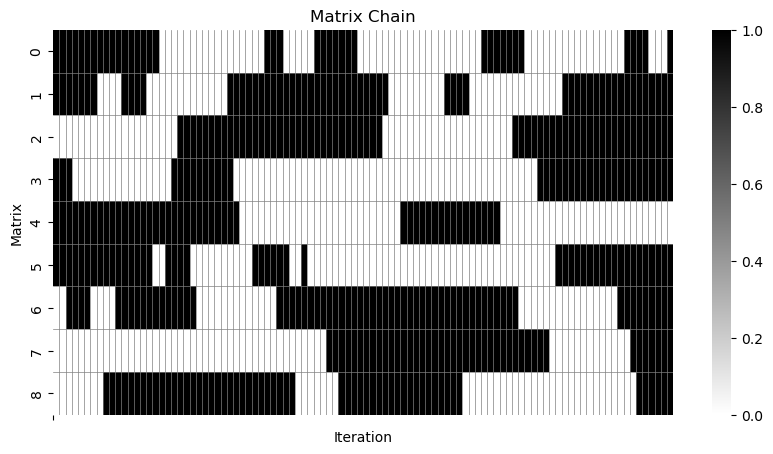

In [156]:
# look chain
plot_X_heatmap(X_q2)

In [157]:
# get proba of all diagonal being 1s
proba_all_diagonal_ones(X_q1)

0.42

### Do it for q1

In [160]:
# lambdas to test
list_lambs = [0, 1, 3]
p_lists = [0.5, 0.8]

# sample for p's and lam's for kernel_q1
for p in p_lists:
    for lam in list_lambs:
        # sample
        X_q1 = mh_blli_matrix(
            f=dmatrix,
            qkernel=sample_q1,
            n_matrix=4,
            p=p,
            lam=lam,
            n=5e+4,
            burn_in=5e+3
        )
        # rejection
        print(f"Rejection for p={p} and lam={lam}: {X_q1['rejection']:.2%}")
        # proba
        print(f"Proba for p={p} and lam={lam}: {proba_all_diagonal_ones(X_q1):.2%}")

100%|██████████| 54999/54999 [00:08<00:00, 6802.83it/s]


Rejection for p=0.5 and lam=0: 0.00%
Proba for p=0.5 and lam=0: 6.24%


100%|██████████| 54999/54999 [00:08<00:00, 6555.25it/s]


Rejection for p=0.5 and lam=1: 93.08%
Proba for p=0.5 and lam=1: 21.08%


100%|██████████| 54999/54999 [00:07<00:00, 7245.21it/s]


Rejection for p=0.5 and lam=3: 99.99%
Proba for p=0.5 and lam=3: 57.27%


100%|██████████| 54999/54999 [00:07<00:00, 7242.77it/s]


Rejection for p=0.8 and lam=0: 76.70%
Proba for p=0.8 and lam=0: 77.80%


100%|██████████| 54999/54999 [00:07<00:00, 7262.38it/s]


Rejection for p=0.8 and lam=1: 96.41%
Proba for p=0.8 and lam=1: 98.01%


100%|██████████| 54999/54999 [00:08<00:00, 6750.21it/s]

Rejection for p=0.8 and lam=3: 97.24%
Proba for p=0.8 and lam=3: 99.96%


### Do it for q2

In [161]:
# lambdas to test
list_lambs = [0, 1, 3]
p_lists = [0.5, 0.8]

# sample for p's and lam's for kernel_q2
for p in p_lists:
    for lam in list_lambs:
        # sample
        X_q1 = mh_blli_matrix(
            f=dmatrix,
            qkernel=sample_q2,
            n_matrix=4,
            p=p,
            lam=lam,
            n=5e+4,
            burn_in=5e+3
        )
        # rejection
        print(f"Rejection for p={p} and lam={lam}: {X_q1['rejection']:.2%}")
        # proba
        print(f"Proba for p={p} and lam={lam}: {proba_all_diagonal_ones(X_q1):.2%}")

100%|██████████| 54999/54999 [00:09<00:00, 5979.35it/s]


Rejection for p=0.5 and lam=0: 0.00%
Proba for p=0.5 and lam=0: 5.90%


100%|██████████| 54999/54999 [00:09<00:00, 6033.20it/s]


Rejection for p=0.5 and lam=1: 35.37%
Proba for p=0.5 and lam=1: 21.05%


100%|██████████| 54999/54999 [00:09<00:00, 6054.96it/s]


Rejection for p=0.5 and lam=3: 49.46%
Proba for p=0.5 and lam=3: 0.00%


100%|██████████| 54999/54999 [00:09<00:00, 6100.45it/s]


Rejection for p=0.8 and lam=0: 30.27%
Proba for p=0.8 and lam=0: 40.14%


100%|██████████| 54999/54999 [00:09<00:00, 5982.46it/s]


Rejection for p=0.8 and lam=1: 48.18%
Proba for p=0.8 and lam=1: 92.26%


100%|██████████| 54999/54999 [00:09<00:00, 5839.90it/s]

Rejection for p=0.8 and lam=3: 50.21%
Proba for p=0.8 and lam=3: 99.73%


# Problem 6: Gibbs Sampling for parameter transformation

In [3]:
# data
x = np.array([0.4, 0.01, 0.2, 0.1, 2.1, 0.1, 0.9, 2.4, 0.1, 0.2])

(array([6., 1., 0., 1., 0., 0., 0., 0., 1., 1.]),
 array([0.01 , 0.249, 0.488, 0.727, 0.966, 1.205, 1.444, 1.683, 1.922,
        2.161, 2.4  ]),
 <BarContainer object of 10 artists>)

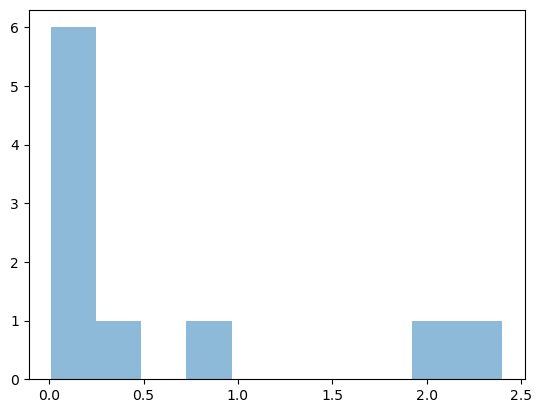

In [6]:
# look at the data
plt.hist(x, bins=10, alpha=0.5)

(array([1., 0., 0., 0., 3., 2., 1., 0., 1., 2.]),
 array([-4.60517019, -4.05710629, -3.5090424 , -2.96097851, -2.41291462,
        -1.86485072, -1.31678683, -0.76872294, -0.22065905,  0.32740485,
         0.87546874]),
 <BarContainer object of 10 artists>)

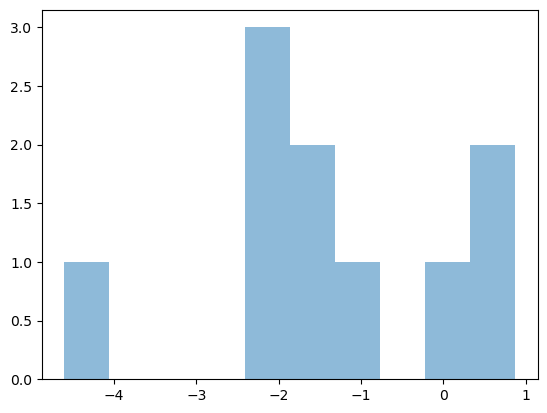

In [7]:
# lok log data
plt.hist(np.log(x), bins=10, alpha=0.5)

## S1: Model

In [35]:
# part 1: fit a exponential distribution using prior over log(theta)
with pm.Model() as model_exp:
    # prior
    log_theta = pm.Flat('log_theta')  # non-informative prior
    theta = pm.Deterministic('theta', pm.math.exp(log_theta))
    inv_theta = pm.Deterministic('inv_theta', 1/theta)

    # likelihood
    y = pm.Exponential('y', lam=pm.math.exp(log_theta), observed=x)

    # fit model
    idata = pm.sample(
        draws=1000, tune=500,  # 1000 samples, 500 burn-in
        random_seed=42, chains=4, cores=4, progressbar=True
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.


## S2: Plot Trace

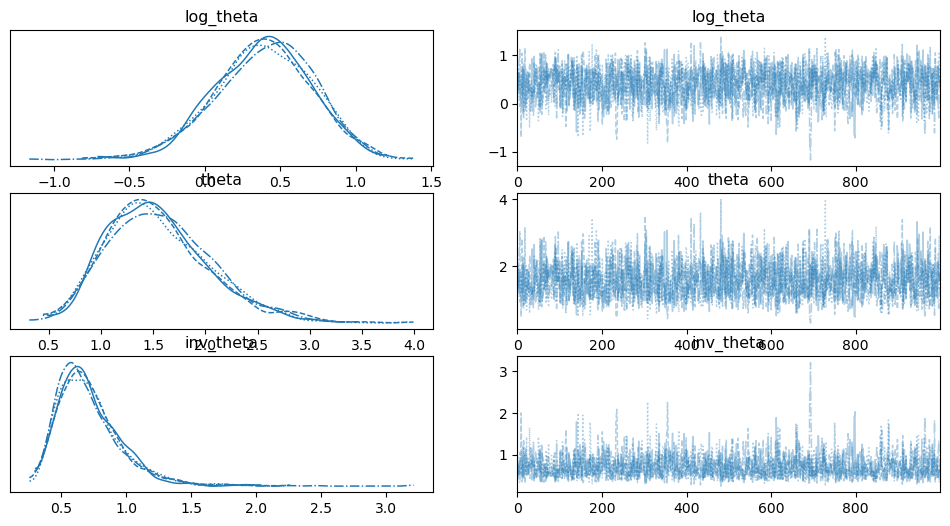

In [36]:
# plot trace
az.plot_trace(idata)
plt.show()

array([<Axes: title={'center': 'log_theta'}>,
       <Axes: title={'center': 'theta'}>,
       <Axes: title={'center': 'inv_theta'}>], dtype=object)

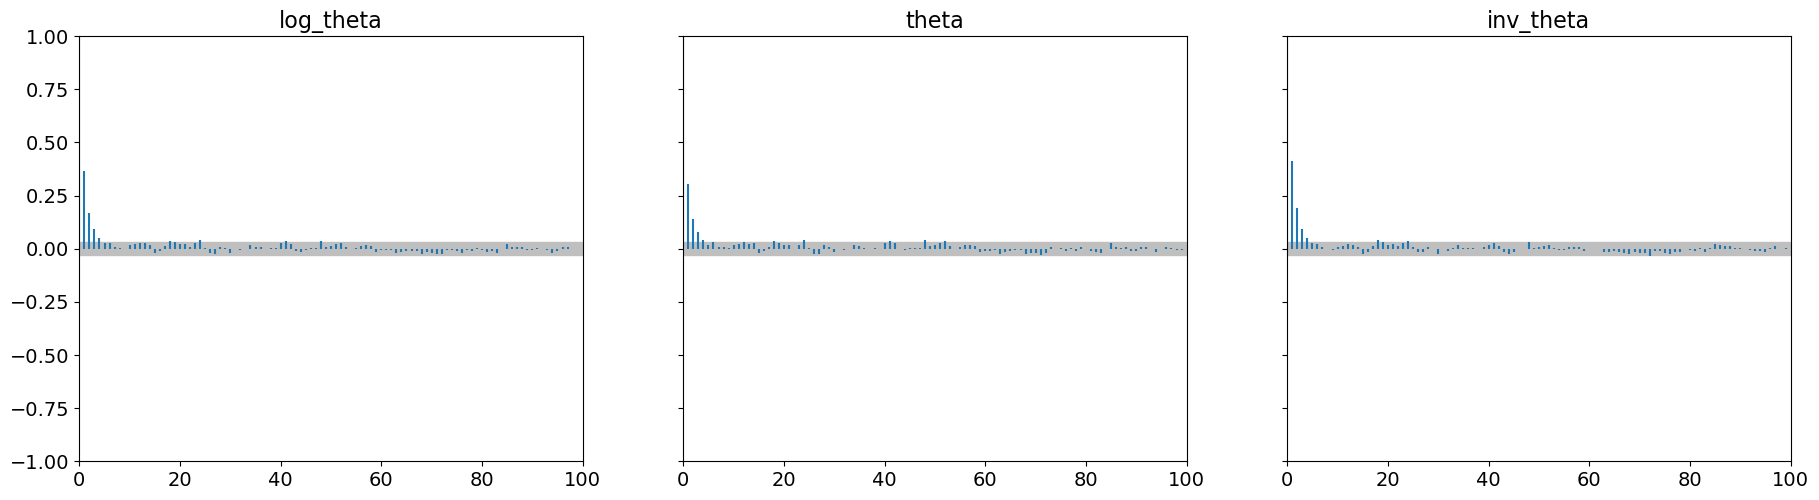

In [37]:
# autocorrelation
az.plot_autocorr(idata, combined=True)

In [38]:
# summary of trace
az.summary(idata, round_to=2, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_theta,0.39,0.32,-0.14,0.91,0.01,0.01,1645.28,2394.72,1.0
theta,1.55,0.49,0.80,2.34,0.01,0.01,1645.28,2394.72,1.0
inv_theta,0.72,0.25,0.35,1.06,0.01,0.00,1645.28,2394.72,1.0


## S3: $Y \sim Gamma(n, \theta)$

Where $n$ is the size of $\underline{X}$.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 13 seconds.


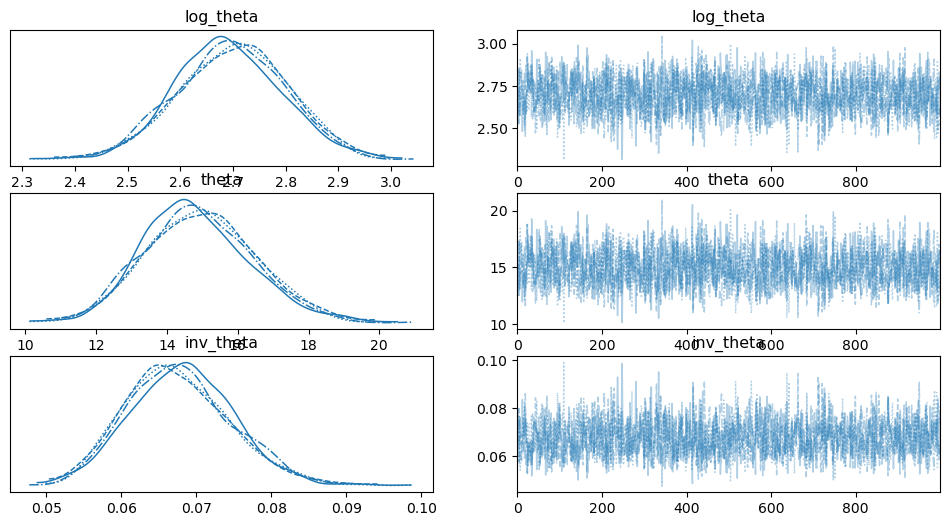

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_theta,2.70,0.10,2.54,2.87,0.00,0.00,1710.13,2574.1,1.0
theta,14.92,1.53,12.27,17.26,0.04,0.03,1710.13,2574.1,1.0
inv_theta,0.07,0.01,0.06,0.08,0.00,0.00,1710.13,2574.1,1.0


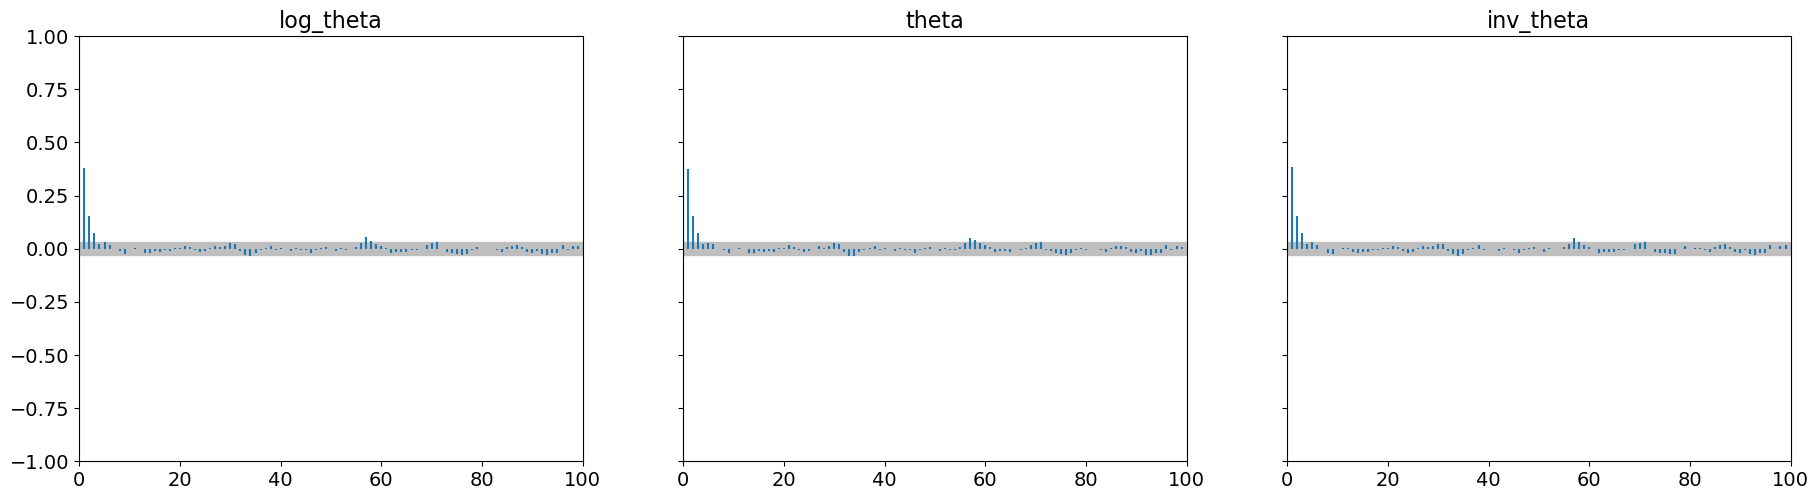

In [33]:
# part 1: fit a exponential distribution using prior over log(theta)
with pm.Model() as model_exp:
    # prior
    log_theta = pm.Normal('log_theta', mu=0, sigma=1)
    theta = pm.Deterministic('theta', pm.math.exp(log_theta))
    inv_theta = pm.Deterministic('inv_theta', 1/theta)

    # likelihood
    y = pm.Gamma('y', alpha=x.shape[0], beta=pm.math.exp(log_theta), observed=x)

    # fit model
    idata = pm.sample(
        draws=1000, tune=500,  # 1000 samples, 500 burn-in
        random_seed=42, chains=4, cores=4, progressbar=True
        )

# plot trace
az.plot_trace(idata)
plt.show()

# autocorrelation
az.plot_autocorr(idata, combined=True)

# summary of trace
az.summary(idata, round_to=2, hdi_prob=0.9)

## S3: $Y \sim LogNormal(\theta, 1)$


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.


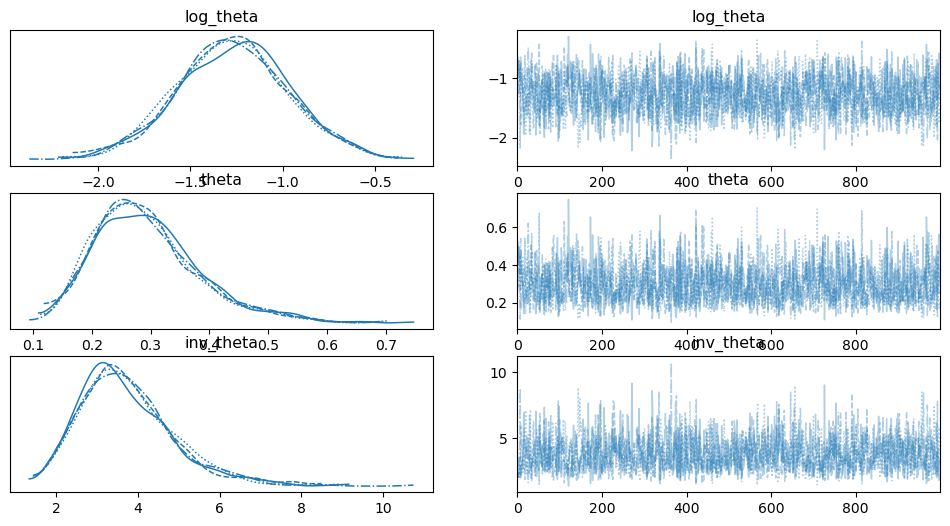

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_theta,-1.27,0.30,-1.79,-0.78,0.01,0.01,1435.21,2504.39,1.0
theta,0.29,0.09,0.15,0.43,0.00,0.00,1435.21,2504.39,1.0
inv_theta,3.73,1.15,1.85,5.33,0.03,0.02,1435.21,2504.39,1.0


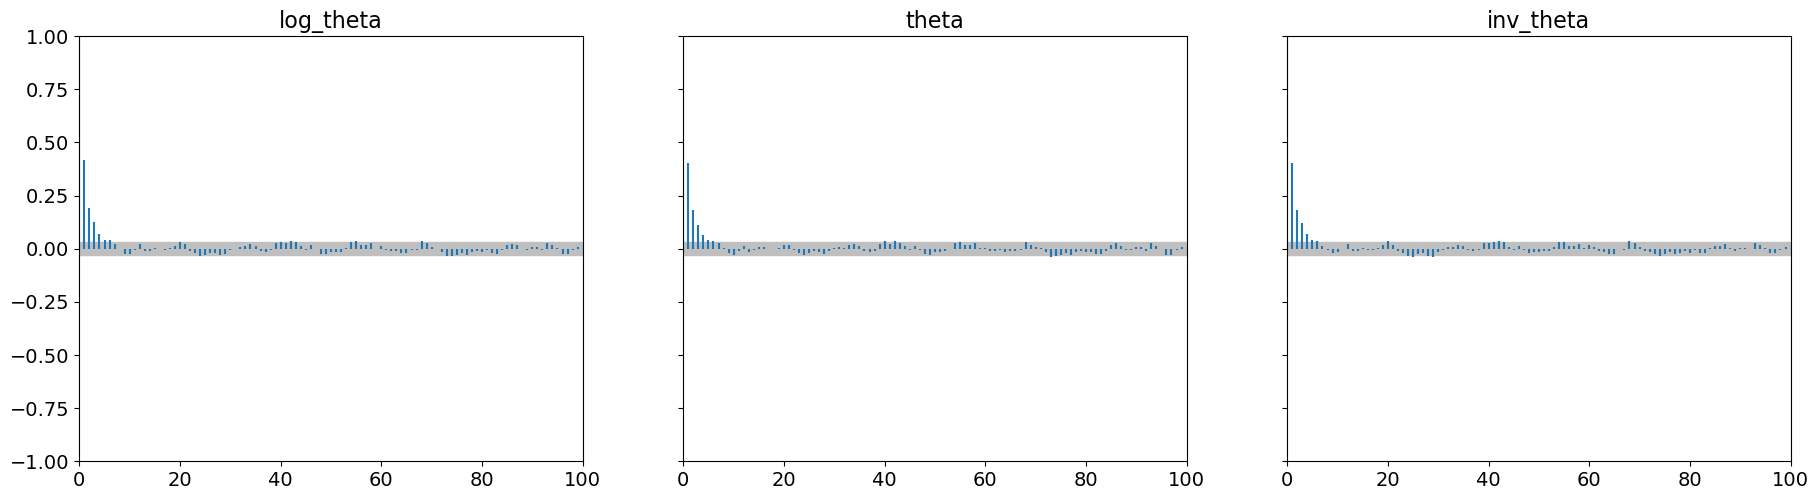

In [39]:
# part 1: fit a exponential distribution using prior over log(theta)
with pm.Model() as model_exp:
    # prior
    log_theta = pm.Normal('log_theta', mu=0, sigma=1)
    theta = pm.Deterministic('theta', pm.math.exp(log_theta))
    inv_theta = pm.Deterministic('inv_theta', 1/theta)

    # likelihood
    y = pm.LogNormal('y', mu=log_theta, sigma=1, observed=x)

    # fit model
    idata = pm.sample(
        draws=1000, tune=500,  # 1000 samples, 500 burn-in
        random_seed=42, chains=4, cores=4, progressbar=True
        )

# plot trace
az.plot_trace(idata)
plt.show()

# autocorrelation
az.plot_autocorr(idata, combined=True)

# summary of trace
az.summary(idata, round_to=2, hdi_prob=0.9)